# Simple implementation af Kalman filteret
Koden er nu skrevet sådan at $F$ er afhængig af tid, da vores koordinater indgår i dens udregning. Vi skal have nogle anre ligninger i spil for at kunne lave den uden det
<br>
<b>OBS OBS OBS OBS OBS</b> <br>
<b>Læs ovenfor</b>
\begin{align*}
    \intertext{kinematic and observations model}
    \mathbf{x}[n]&=\Phi \mathbf{x}[n-1] + \mathbf{u}[n], \\
    \mathbf{z}[n]&=\mathbf{x}[n] + \mathbf{w}[n],\\
    \intertext{the prediction and prediction mean square error,}
    \hat{\mathbf{x}}[n|n-1]&=\Phi\hat{\mathbf{x}}[n-1|n-1], \\
    M[n|n-1]&=\Phi M[n-1|n-1]\Phi^\top + S_{\mathbf{u}}, \\
    \intertext{the Kalman gain,}
    K[n]&=M[n|n-1](S_{\mathbf{w}}+M[n|n-1])^{-1},\\
    \intertext{and the correction and estimate mean square error,}
    \hat{\mathbf{x}}[n|n]&=\hat{\mathbf{x}}[n|n-1]+K[n](\mathbf{z}[n]-\hat{\mathbf{x}}[n|n-1]),\\
    M[n|n]&=(I-K[n])M[n|n-1].
\end{align*}

In [1]:
import numpy as np
import matplotlib.pyplot as plt


distance = np.load("sat_2_100deg/distance.npy")
distances = np.load("sat_2_100deg/distances.npy")
velocity = np.load("sat_2_100deg/velocity.npy")
velocities = np.load("sat_2_100deg/velocties.npy")
x_state = np.hstack((distances, velocities))

In [2]:
class Kalman:
    z = []

    x_predictions = []
    x_corrections = []

    M_predictions = []
    M_corrections = []

    mu = 3.986004418e14 # wiki "standard gravitational parameter"

    def __init__(self, S_u, S_w, x_guess, M_guess, dt):
        self.S_u = S_u
        self.S_w = S_w
        self.dt = dt

        self.dim = x_guess.shape[0]
        self.x_corrections.append(x_guess)
        self.M_corrections.append(M_guess)


    def __F(self, rx, ry, rz):
        r_i, r_j, r_k = rx, ry, rz
        r = np.sqrt(rx**2 + ry**2 + rz**2)
        F1, F2, F4 = np.zeros((3, 3)), np.eye(3), np.zeros((3, 3))
        F3 = np.asanyarray([[-self.mu/(r**3) + (3*self.mu*r_i**2)/(r**5), (3*self.mu*r_i*r_j)/(r**5), (3*self.mu*r_i*r_k)/(r**5)],
                            [(3*self.mu*r_i*r_j)/(r**5), -self.mu/r**3 + (3*self.mu*r_j**2)/(r**5), (3*self.mu*r_j*r_k)/(r**5)],
                            [(3*self.mu*r_i*r_k)/(r**5), (3*self.mu*r_j*r_k)/(r**5), -(self.mu)/(r**3) + (3*self.mu*r_k**2)/(r**5)]])
        F_top = np.concatenate((F1, F2), axis=1)
        F_bot = np.concatenate((F3, F4), axis=1)
        F = np.concatenate((F_top, F_bot))

        return F


    def __phi(self, x_state):
        F = self.__F(x_state[0], x_state[1], x_state[2])

        return np.eye(self.dim) + self.dt*F


    def __kalman_gain(self):
        return self.M_predictions[-1] @ np.linalg.inv(self.S_w+self.M_predictions[-1])


    def make_prediction(self):
        x = self.x_corrections[-1]
        M = self.M_corrections[-1]
        phi = self.__phi(x)

        x_guess = phi @ x
        M_guess = phi @ M @ phi.T + self.S_u

        self.x_predictions.append(x_guess)
        self.M_predictions.append(M_guess)


    def make_observation(self, new_x):
        self.z.append(new_x + np.random.normal(np.zeros((self.dim, self.dim)), self.S_w)[0])


    def make_correction(self):
        xp = self.x_predictions[-1]
        Mp = self.M_predictions[-1]
        K = self.__kalman_gain()
        z = self.z[-1]
        I = np.eye(self.dim)

        x_correction = xp + K @ (z-xp)
        M_correction = (I - K) @ Mp

        self.x_corrections.append(x_correction)
        self.M_corrections.append(M_correction)


    def run_sim(self, x):
        l = len(x)
        i = 0
        while len(self.x_corrections) < l:
            self.make_prediction()
            self.make_observation(x[i])
            self.make_correction()
            i += 1

In [3]:
cov_w, cov_u = [np.eye(6)]*2
x_initial_guess, M_initial_guess = x_state[0], np.eye(6)
kf = Kalman(cov_u, cov_w, x_initial_guess, M_initial_guess, 0.1)
kf.run_sim(x_state)

In [4]:
track = np.asarray(kf.x_corrections)
xt, yt, zt = track[:, 0], track[:, 1], track[:, 2]
xr, yr, zr = x_state[:, 0], x_state[:, 1], x_state[:, 2]

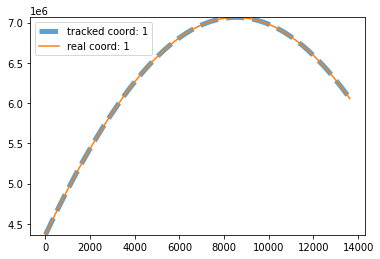

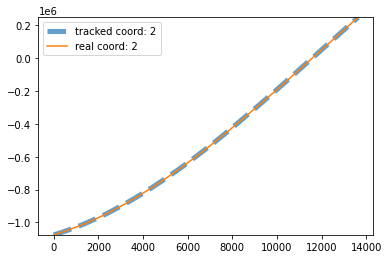

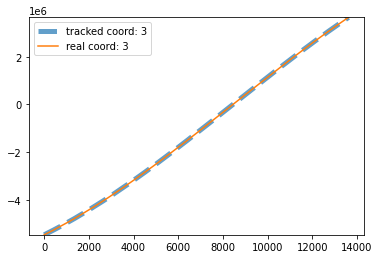

In [5]:
for i in range(3):
    plt.plot(track[:, i], label="tracked coord: " + str(i+1), lw=5, alpha=0.7, ls='--')
    plt.plot(x_state[:, i], label="real coord: " + str(i+1))
    plt.ylim((np.min(x_state[:, i]), np.max(x_state[:, i])))
    plt.legend()
    plt.show()